*A general note on this notebook* - while the analysis for this study of iPTF 16abc is being conducted in an open fashion, we have not obtained permission to share the data of other researchers.

If you are hoping to run this analysis locally, you will need to adjust the absolute paths to the velocity data read in below. These data are from [Blondin et al. 2012](http://adsabs.harvard.edu/abs/2012AJ....143..126B), and I suspect that Stephane Blondin will happily share them with you.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [20]:
data_dir = "/Users/adamamiller/astronomy/SN_Ia_models/ObsData/Blondin2012/"
ss_dat = pd.read_csv(data_dir + "vabsSiII6355_SS.csv")
cl_dat = pd.read_csv(data_dir + "vabsSiII6355_CL.csv")
cn_dat = pd.read_csv(data_dir + "vabsSiII6355_CN.csv")
bl_dat = pd.read_csv(data_dir + "vabsSiII6355_BL.csv")

In [22]:
ss_sne = ss_dat['SN'].unique()
cl_sne = cl_dat['SN'].unique()
cn_sne = cn_dat['SN'].unique()
bl_sne = bl_dat['SN'].unique()

<IPython.core.display.Javascript object>


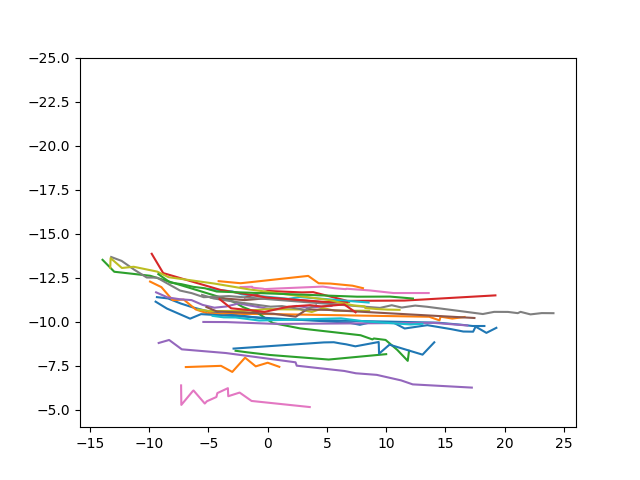

<IPython.core.display.Javascript object>


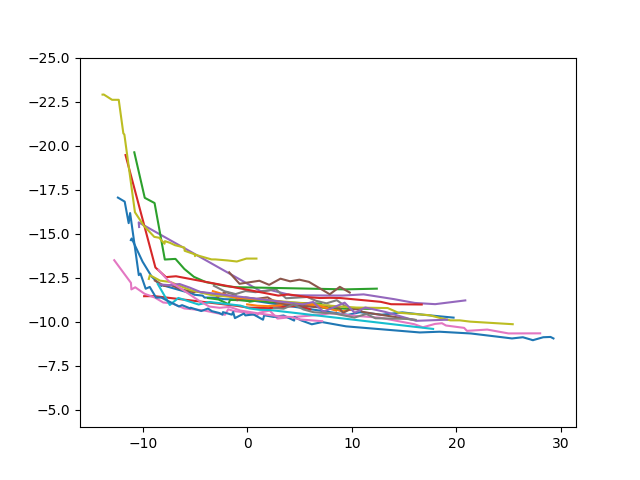

<IPython.core.display.Javascript object>


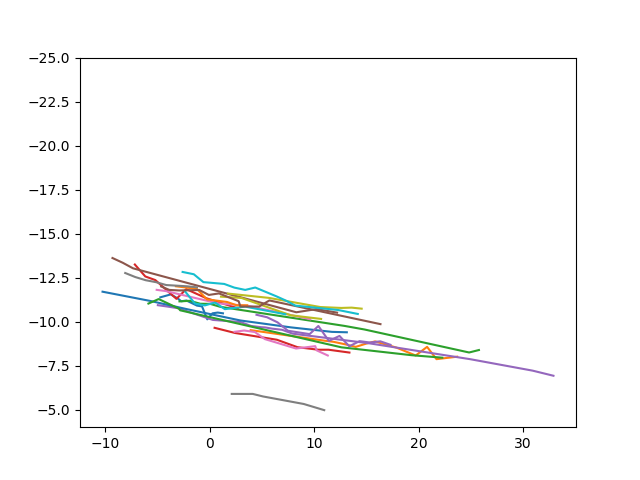

<IPython.core.display.Javascript object>


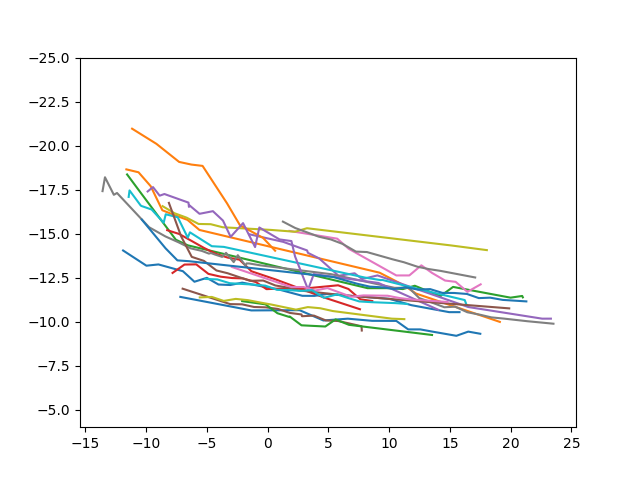

In [24]:
plt.figure()
for ss_sn in ss_sne:
    plt.plot(ss_dat["age"].where(ss_dat["SN"] == ss_sn), ss_dat["vabs"].where(ss_dat["SN"] == ss_sn))
    plt.ylim(-4,-25)
plt.figure()
for cn_sn in cn_sne:
    plt.plot(cn_dat["age"].where(cn_dat["SN"] == cn_sn), cn_dat["vabs"].where(cn_dat["SN"] == cn_sn))
    plt.ylim(-4,-25)
plt.figure()
for cl_sn in cl_sne:
    plt.plot(cl_dat["age"].where(cl_dat["SN"] == cl_sn), cl_dat["vabs"].where(cl_dat["SN"] == cl_sn))
    plt.ylim(-4,-25)
plt.figure()
for bl_sn in bl_sne:
    plt.plot(bl_dat["age"].where(bl_dat["SN"] == bl_sn), bl_dat["vabs"].where(bl_dat["SN"] == bl_sn))
    plt.ylim(-4,-25)

In [56]:
t_grid = np.linspace(-20,40,61)
ss_vel = np.ma.empty((len(ss_sne), len(t_grid)))

In [57]:
for i_sn, ss_sn in enumerate(ss_sne):
    this_sn = np.where(ss_dat["SN"] == ss_sn)
    t_sn = ss_dat["age"].ix[this_sn]
    v_sn = ss_dat["vabs"].ix[this_sn]
    v_interp = np.interp(t_grid, t_sn, v_sn)
    ss_vel[i_sn] = v_interp
    ss_vel[i_sn] = np.ma.masked_where((t_grid < min(t_sn)) | (t_grid > max(t_sn)), ss_vel[i_sn])

<IPython.core.display.Javascript object>


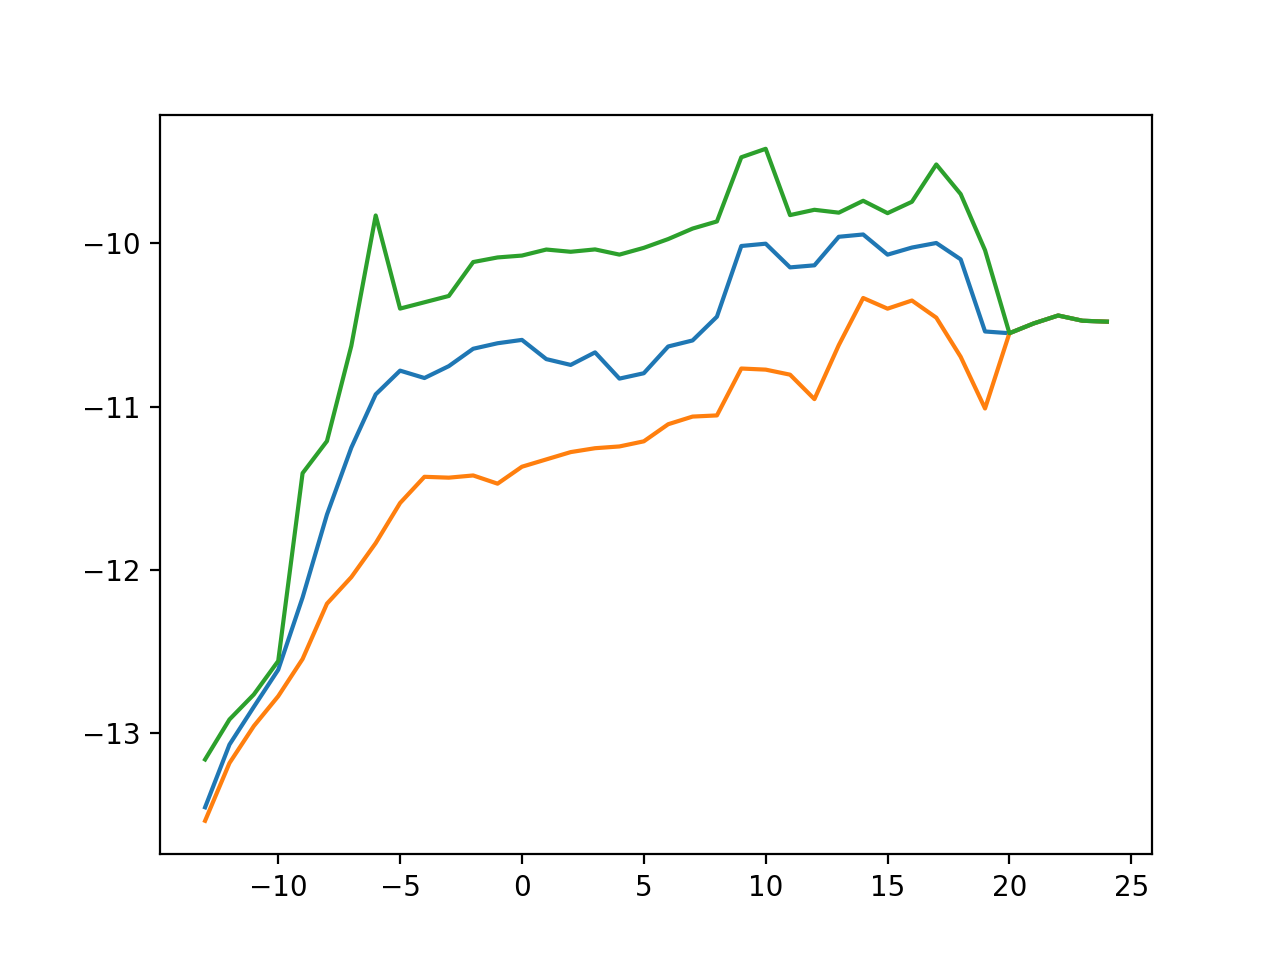

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [67]:
plt.figure()
plt.plot(t_grid, np.ma.median(ss_vel, axis = 0))
plt.plot(t_grid, np.nanpercentile(np.ma.filled(ss_vel, np.nan), 25, axis = 0))
plt.plot(t_grid, np.nanpercentile(np.ma.filled(ss_vel, np.nan), 75, axis = 0))

<IPython.core.display.Javascript object>


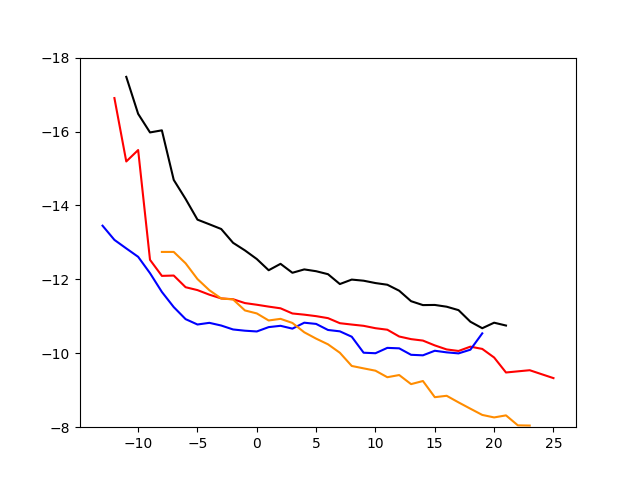

(-8, -18)

In [116]:
plt.figure()
t_grid = np.linspace(-20,40,61)
for branch_class, line_col in zip([bl_dat, cn_dat, ss_dat, cl_dat], ["k","r","b","DarkOrange"]):
    sne = branch_class['SN'].unique()
    vel_arr = np.ma.empty((len(sne), len(t_grid)))
    for i_sn, sn in enumerate(sne):
        this_sn = np.where(branch_class["SN"] == sn)
        t_sn = branch_class["age"].ix[this_sn]
        v_sn = branch_class["vabs"].ix[this_sn]
        v_interp = np.interp(t_grid, t_sn, v_sn)
        vel_arr[i_sn] = v_interp
        vel_arr[i_sn] = np.ma.masked_where((t_grid < min(t_sn)) | (t_grid > max(t_sn)), vel_arr[i_sn])
    min_3_vels = np.where(np.ma.masked_array.count(vel_arr, axis = 0) >= 3)
    plt.plot(t_grid[min_3_vels], np.ma.median(vel_arr, axis = 0)[min_3_vels], color = line_col)
#     plt.plot(t_grid, np.nanpercentile(np.ma.filled(vel_arr, np.nan), 50, axis = 0), 
#              '-', color = line_col)
#     plt.plot(t_grid[min_3_vels], np.nanpercentile(np.ma.filled(vel_arr, np.nan), 25, axis = 0)[min_3_vels], 
#              '--', color = line_col)
#     plt.plot(t_grid[min_3_vels], np.nanpercentile(np.ma.filled(vel_arr, np.nan), 75, axis = 0)[min_3_vels], 
#              '--', color = line_col)
plt.ylim(-8, -18)

## Measuring the Si II velocity of 16abc

The approach here will be to measure the minimum of absorption. I will do that following the convolution of the spectrum with a FWHM = 2000 km/s gaussian kernel.

In [ ]:
from constantVelocityKernel.specconvolve import convolve_with_constant_velocity_kernel

z_16abc = 0.0234
kern_vel_fwhm = 2e3 # kernel velocity FWHM in km/s
spec_list = ['../data/spectroscopy/16fnm_20160903.36_P200_v1.ascii',
             '../data/spectroscopy/16fnm_20160905_NOT_v1.ascii',
             '../data/spectroscopy/16fnm_20160909_NOT_v1.ascii',
             '../data/spectroscopy/16fnm_20160930_Keck1_v1.ascii',
             '../data/spectroscopy/16fnm_20161128_Keck1_v1.ascii']

vSiII = np.empty(len(spec_list))

for spec_num, spec_file in enumerate(spec_list):
    spec = np.loadtxt(spec_file, 
                      usecols = [0, 1], unpack = True)

    wave = spec[0]/(1+z_16abc)
    flux = spec[1]
    opt_region = np.where((wave >= 3600) & (wave < 10000))

    box_flux = np.repeat(flux, 2)
    box_wave = np.repeat((wave[:-1] + wave[1:])/2, 2)
    box_wave = np.append(box_wave[0] - np.diff(wave)[0], box_wave)
    box_wave = np.append(box_wave, box_wave[-1] + np.diff(wave)[-1])

    interp_grid, var_kern_flux = convolve_with_constant_velocity_kernel(wave[opt_region], flux[opt_region], kern_vel_fwhm)
    
    SiII_region = np.where( (interp_grid > 6255) & (interp_grid < 6375) )
    SiII_lambdaAtMin = interp_grid[SiII_region][np.argmin(var_kern_flux[SiII_region])]
    SiII_velAtMin = (6355 - SiII_lambdaAtMin)/6355*c.value*1e-3

    vSiII[spec_num] = SiII_velAtMin
